# The Rise of LGBT shows
Introduction thing

## Data Description

Our dataset is a collection of information about Netflix shows as of 2019. Each obsevation contains information about a Netflix show's unique ID, its type (i.e. whether it is a TV Show or a movie), title, director, cast, country (where it was produced), release date, release year, TV rating, duration, genre, and description.

The dataset 'Netflix Movies and TV Shows' was collected from Flixable, a third-party Netflix search engine. Flixable was created in 2018 by Ville Salminen, and it came with additional advanced search functionality which was missing from the implemented search engine of Netflix. The data was extracted from the Flixable database through the use of API calls.

Currently, Netlflix does not have their API publicly available, and Flixable has not openly disclosed how the web site was able to acquire the data for its database. Despite the popularity of the aforementioned site, we cannot confirm whether the dataset that was extracted from Flixable is reliable. Moreover, considering that the latest update for the dataset was on November 2019, the conclusions made in this case study may not be representative of the current Netflix shows as of September, 2020.

## Exploratory Data Analysis

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

Something load dataset

In [2]:
netflix_df = pd.read_csv("./netflix_titles.csv")
netflix_df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...


In [3]:
netflix_df['director'].unique()

array(['Richard Finn, Tim Maltby', nan, 'Fernando Lebrija', ...,
       'Vikramaditya Motwane, Anurag Kashyap', 'Jung-ah Im', 'Onur Ünlü'],
      dtype=object)

Remove duplicates dito ba?? ewan

#### Checking for `NAN`s

In [4]:
netflix_df.isnull().any()

show_id         False
type            False
title           False
director         True
cast             True
country          True
date_added       True
release_year    False
rating           True
duration        False
listed_in       False
description     False
dtype: bool

We see here that the `description` and `listed_in` variables do not have `Nan`/`null` values. Hence, no need to drop rows (for this question, at least) or do imputation. 

#### Checking for duplicates

The `description` variable is a good feature to check for duplicates as the synopsis are expectedly unique for each show.

In [5]:
netflix_desc_duplicate = netflix_df['description'].value_counts().reset_index(name="description").query("description > 1")
print(netflix_desc_duplicate)
print("Repeated descriptions:", len(netflix_desc_duplicate))
print("Repeated shows:", netflix_desc_duplicate['description'].sum())

                                               index  description
0  A surly septuagenarian gets another chance at ...            3
1  When Elastigirl gets recruited for a high-prof...            2
2  An aspiring musician battles age-old caste div...            2
3  As a series of murders hit close to home, a vi...            2
4  A ruthless businessman’s mission to expose ele...            2
5  A young Han Solo tries to settle an old score ...            2
6  An affable, newly appointed college warden pro...            2
Repeated descriptions: 7
Repeated shows: 15


There are 7 repeated descriptions, and a total of 15 repeated shows based on our assumption that observations with the same description are the same show. To further confirm this, we can look at the other variables of the observations corresponding to these descriptions.

In [6]:
netflix_df.loc[netflix_df["description"].isin(netflix_desc_duplicate["index"])]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
119,81186758,Movie,Oh! Baby (Malayalam),B. V. Nandini Reddy,"Samantha Ruth Prabhu, Lakshmi, Rajendraprasad,...",India,"September 25, 2019",2019,TV-14,146 min,"Comedies, International Movies, Music & Musicals",A surly septuagenarian gets another chance at ...
120,81186757,Movie,Oh! Baby (Tamil),B. V. Nandini Reddy,"Samantha Ruth Prabhu, Lakshmi, Rajendraprasad,...",India,"September 25, 2019",2019,TV-14,146 min,"Comedies, International Movies, Music & Musicals",A surly septuagenarian gets another chance at ...
252,81093951,Movie,Oh! Baby,B. V. Nandini Reddy,"Samantha Ruth Prabhu, Lakshmi, Rajendraprasad,...",India,"September 14, 2019",2019,TV-14,157 min,"Comedies, International Movies, Music & Musicals",A surly septuagenarian gets another chance at ...
2123,81075235,Movie,Sarkar,A.R. Murugadoss,"Vijay, Varalakshmi Sarathkumar, Keerthi Suresh...",India,"March 2, 2019",2018,TV-MA,162 min,"Action & Adventure, Dramas, International Movies",A ruthless businessman’s mission to expose ele...
2124,81072516,Movie,Sarkar,A.R. Murugadoss,"Vijay, Varalakshmi Sarathkumar, Keerthi Suresh...",India,"March 2, 2019",2018,TV-MA,162 min,"Action & Adventure, Dramas, International Movies",A ruthless businessman’s mission to expose ele...
2312,81083971,Movie,Sarvam Thaala Mayam (Tamil Version),Rajiv Menon,"G.V. Prakash Kumar, Nedumudi Venu, Aparna Bala...",India,"March 1, 2019",2018,TV-14,131 min,"Dramas, International Movies, Music & Musicals",An aspiring musician battles age-old caste div...
3184,80220814,Movie,Solo: A Star Wars Story,Ron Howard,"Alden Ehrenreich, Woody Harrelson, Emilia Clar...",United States,"January 9, 2019",2018,PG-13,135 min,"Action & Adventure, Children & Family Movies, ...",A young Han Solo tries to settle an old score ...
3185,81046962,Movie,Solo: A Star Wars Story (Spanish Version),Ron Howard,"Alden Ehrenreich, Woody Harrelson, Emilia Clar...",United States,"January 9, 2019",2018,PG-13,135 min,"Action & Adventure, Children & Family Movies, ...",A young Han Solo tries to settle an old score ...
3242,80221639,Movie,The Incredibles 2,Brad Bird,"Craig T. Nelson, Holly Hunter, Samuel L. Jacks...",United States,"January 30, 2019",2018,PG,118 min,"Children & Family Movies, Comedies",When Elastigirl gets recruited for a high-prof...
3752,81059388,Movie,Incredibles 2 (Spanish Version),Brad Bird,"Víctor Trujillo, Consuelo Duval, Darío T. Pie,...",United States,"February 8, 2019",2018,PG,118 min,"Children & Family Movies, Comedies",When Elastigirl gets recruited for a high-prof...


Closely examining the observations reveals that the only differences in the observations are the `date_added` and the `title` variables. The date when the show is added doesn't give much insight as it does not give relevant context to the similarity of the show (i.e. different versions of a show can be added at different times, and vice versa). However, the title &mdash; at least in the results above &mdash; are descriptive in the differences.

The titles show that there are multiple versions due to langauge. The show *The Incredibles 2*, for instance, has both the original, and the Spanish version. Meanwhile, the movie *Oh! Baby* has two other versions: the Malalayam and Tamil. The only observation which didn't show any difference was for the movie *Sarkar* whose titles (there are 2 observations for this movie) do not indicate versions. This may either be a data collection error, or the title simply does not show which version it is.

Nonetheless, all the duplicates will be cleaned in the same way. The "original" version (i.e. the one without a parenthesis stating the version, or if not applicable, the first entry that appears in the dataset for simplicity) will be retained. 

This step is important because duplicates will affect the weight of the words during feature extraction. Thus, there would be bias for a particular show which would produce results that are not representative of the show's listed genre.

Because there are only few duplicates, we can manually remove the offending observations via `show_id`.

In [7]:
show_id_remove_list = [81186758, 81186757, 81072516, 81046962, 81059388, 81151877, 81074135, 81091424]

netflix_df.loc[(netflix_df["description"].isin(netflix_desc_duplicate["index"])) & (~netflix_df["show_id"].isin(show_id_remove_list))]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
252,81093951,Movie,Oh! Baby,B. V. Nandini Reddy,"Samantha Ruth Prabhu, Lakshmi, Rajendraprasad,...",India,"September 14, 2019",2019,TV-14,157 min,"Comedies, International Movies, Music & Musicals",A surly septuagenarian gets another chance at ...
2123,81075235,Movie,Sarkar,A.R. Murugadoss,"Vijay, Varalakshmi Sarathkumar, Keerthi Suresh...",India,"March 2, 2019",2018,TV-MA,162 min,"Action & Adventure, Dramas, International Movies",A ruthless businessman’s mission to expose ele...
2312,81083971,Movie,Sarvam Thaala Mayam (Tamil Version),Rajiv Menon,"G.V. Prakash Kumar, Nedumudi Venu, Aparna Bala...",India,"March 1, 2019",2018,TV-14,131 min,"Dramas, International Movies, Music & Musicals",An aspiring musician battles age-old caste div...
3184,80220814,Movie,Solo: A Star Wars Story,Ron Howard,"Alden Ehrenreich, Woody Harrelson, Emilia Clar...",United States,"January 9, 2019",2018,PG-13,135 min,"Action & Adventure, Children & Family Movies, ...",A young Han Solo tries to settle an old score ...
3242,80221639,Movie,The Incredibles 2,Brad Bird,"Craig T. Nelson, Holly Hunter, Samuel L. Jacks...",United States,"January 30, 2019",2018,PG,118 min,"Children & Family Movies, Comedies",When Elastigirl gets recruited for a high-prof...
4879,81151880,Movie,Game Over (Hindi Version),Ashwin Saravanan,"Taapsee Pannu, Vinodhini, Parvathi T, Ramya Su...","India, Turkey","August 21, 2019",2019,TV-MA,98 min,"Horror Movies, International Movies, Thrillers","As a series of murders hit close to home, a vi..."
5212,81091423,Movie,Petta,Karthik Subbaraj,"Rajnikanth, Vijay Sethupathi, M. Sasikumar, Na...",India,"April 5, 2019",2019,TV-14,170 min,"Action & Adventure, Comedies, Dramas","An affable, newly appointed college warden pro..."


The above shows the observations that will be retained from all the duplicates.

In [8]:
netflix_df_clean = netflix_df[~netflix_df["show_id"].isin(show_id_remove_list)]
netflix_df_clean

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...
...,...,...,...,...,...,...,...,...,...,...,...,...
6229,80000063,TV Show,Red vs. Blue,NaN,"Burnie Burns, Jason Saldaña, Gustavo Sorola, G...",United States,NaN,2015,NR,13 Seasons,"TV Action & Adventure, TV Comedies, TV Sci-Fi ...","This parody of first-person shooter games, mil..."
6230,70286564,TV Show,Maron,NaN,"Marc Maron, Judd Hirsch, Josh Brener, Nora Zeh...",United States,NaN,2016,TV-MA,4 Seasons,TV Comedies,"Marc Maron stars as Marc Maron, who interviews..."
6231,80116008,Movie,Little Baby Bum: Nursery Rhyme Friends,NaN,NaN,NaN,NaN,2016,NaN,60 min,Movies,Nursery rhymes and original music for children...
6232,70281022,TV Show,A Young Doctor's Notebook and Other Stories,NaN,"Daniel Radcliffe, Jon Hamm, Adam Godley, Chris...",United Kingdom,NaN,2013,TV-MA,2 Seasons,"British TV Shows, TV Comedies, TV Dramas","Set during the Russian Revolution, this comic ..."


## Exploratory questions:

#### 1.) What genres appear most frequently among Netflix shows?

For our first exploratory question, we decided to determine what genres are the most popular among Netflix shows. First we take the genres column and isolate the genres per Netflix show. This is because it is possible for a single show to have multiple genres associated to it.

In [9]:
listed_in_series = netflix_df_clean['listed_in']
genre_matrix = []

for string in listed_in_series:
    split_str = string.split(', ')
    genre_matrix.append(split_str)

genre_df = pd.DataFrame(genre_matrix)
genre_list = pd.concat([genre_df[0], genre_df[1], genre_df[2]])
genre_list.dropna(inplace = True)
genre_df


,0,1,2
0,Children & Family Movies,Comedies,None
1,Stand-Up Comedy,None,None
2,Kids' TV,None,None
3,Kids' TV,None,None
4,Comedies,None,None
...,...,...,...
6221,TV Action & Adventure,TV Comedies,TV Sci-Fi & Fantasy
6222,TV Comedies,None,None
6223,Movies,None,None
6224,British TV Shows,TV Comedies,TV Dramas


Now that the genres have been isolated, we can now use a histogram to visualize the number of times a particular genre appeared on a Netflix show.

Text(0.5, 1.0, 'Bar plot of genre count in Netflix shows')

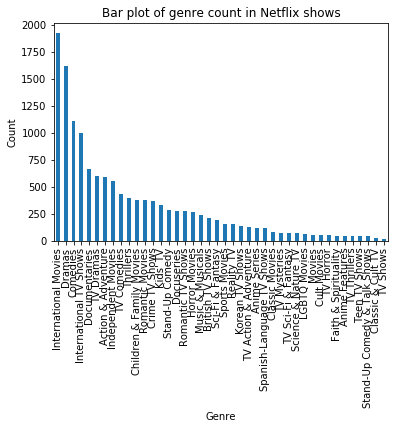

In [10]:
genre_count = genre_list.value_counts()

genre_count.plot.bar()
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Bar plot of genre count in Netflix shows')

Here we can see the ranking of the shows based on its frequency in Netflix shows. We see that 'International Movies' appear most frequently with almost 2000 appearances in the dataset.

#### 2.) What is the trend on the number of International Movies per year 

As we can see from the bar plot of the genre frequency, 'International Movies' was determined to be the most frequent genre in the dataset. Knowing this, the second exploratory question will focus on the trend of 'International Movies' according to its release year in the Netflix dataset. First we need to isolate the shows which are listed as 'International Movies' in the dataset

In [11]:
netflix_df_international = netflix_df_clean
netflix_df_international.insert(12, "isInternationalMV", netflix_df_clean["listed_in"].str.find("International Movies") != -1, True)
netflix_df_international = netflix_df_international[netflix_df_international.isInternationalMV]
netflix_df_international

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,isInternationalMV
6,70304989,Movie,Automata,Gabe Ibáñez,"Antonio Banderas, Dylan McDermott, Melanie Gri...","Bulgaria, United States, Spain, Canada","September 8, 2017",2014,R,110 min,"International Movies, Sci-Fi & Fantasy, Thrillers","In a dystopian future, an insurance adjuster f...",True
11,70299204,Movie,Kidnapping Mr. Heineken,Daniel Alfredson,"Jim Sturgess, Sam Worthington, Ryan Kwanten, A...","Netherlands, Belgium, United Kingdom, United S...","September 8, 2017",2015,R,95 min,"Action & Adventure, Dramas, International Movies","When beer magnate Alfred ""Freddy"" Heineken is ...",True
21,80046728,Movie,Moonwalkers,Antoine Bardou-Jacquet,"Ron Perlman, Rupert Grint, Robert Sheehan, Ste...","France, Belgium","September 8, 2017",2015,R,96 min,"Action & Adventure, Comedies, International Mo...","A brain-addled war vet, a failing band manager...",True
29,70241607,Movie,Laddaland,Sopon Sukdapisit,"Saharat Sangkapreecha, Pok Piyatida Woramusik,...",Thailand,"September 7, 2018",2011,TV-MA,112 min,"Horror Movies, International Movies",When a family moves into an upscale housing de...,True
32,80159586,Movie,The Most Assassinated Woman in the World,Franck Ribière,"Anna Mouglalis, Niels Schneider, André Wilms, ...","Belgium, United Kingdom, United States","September 7, 2018",2018,TV-MA,102 min,"Dramas, International Movies, Thrillers","In 1930s Paris, an actress famous for her gory...",True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5568,80158479,Movie,Salaakhen,A. Salaam,"Shashi Kapoor, Sulakshana Pandit, Mehmood, Sud...",India,"April 1, 2017",1975,TV-14,134 min,"Action & Adventure, International Movies, Musi...",Two close childhood friends take drastically d...,True
5571,80100054,Movie,Skins,Eduardo Casanova,"Ana Polvorosa, Candela Peña, Macarena Gómez, C...",Spain,"April 1, 2017",2017,TV-MA,78 min,"Dramas, International Movies","Deformed, disfigured characters must find a wa...",True
5573,80171439,Movie,The Human Factor: The Untold Story of the Bomb...,Rudradeep Bhattacharjee,NaN,India,"April 1, 2017",2013,TV-PG,53 min,"Documentaries, International Movies, Music & M...",A family of Parsi musicians collectively works...,True
5574,80104237,Movie,The Tenth Man,Daniel Burman,"Alan Sabbagh, Julieta Zylberberg, Usher Barilk...",Argentina,"April 1, 2017",2016,TV-MA,81 min,"Dramas, International Movies",After spending much of his adult life in New Y...,True


Having done this, we can now use a histogram in order to visualize the trend of shows listed as 'International Movies' in the Netlflix dataset

Text(0.5, 1.0, 'Histogram of International Movies per year')

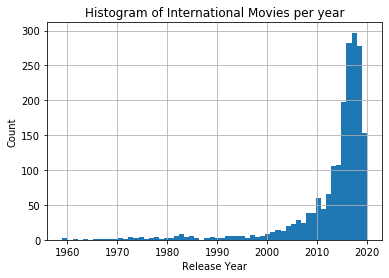

In [12]:
netflix_df_international['release_year'].hist(bins=60)
plt.xlabel('Release Year')
plt.ylabel('Count')
plt.title('Histogram of International Movies per year')

Based on the histogram above, we can see that within the Netflix catalog, there is a large number of shows listed as 'International Movies' which were released towards the latter half of the 2010's. 

In [13]:
netflix_df_2.insert(12, "isLGBT", netflix_df_2["listed_in"].str.find("LGBT") != -1, True)
netflix_df_2

NameError: name 'netflix_df_2' is not defined

In [ ]:
netflix_df_lgbt = netflix_df_2[netflix_df_2["isLGBT"] == True]
netflix_df_lgbt

## Research Question

## Data Modelling

### What are the most common association rules among Netflix genres?

#### Subheader

### Are Netflix descriptions effective classifiers for the LGBTQ genre?

The `description` variable in the dataset refers to Netflix's synopsis of each show. DESCRIBE MORE

- Get not LGBT shows same size as LGBT
- Get features (tfidf, or whatever)
- Get top features (chi2)
- Tas ulet ulet sampling

In [ ]:
netflix_df_international = netflix_df_international[netflix_df_international["isInternationalMV"] == True]
netflix_df_international

In [ ]:
netflix_df_non_international = netflix_df_clean[netflix_df_clean["isInternationalMV"] == False]
netflix_df_non_international

In [ ]:
netflix_df_classifier = pd.concat([netflix_df_non_international, netflix_df_international])
netflix_df_classifier

In [ ]:
vectorizer=TfidfVectorizer()
vectorizer.fit(netflix_df_classifier["description"])
vector=vectorizer.transform(netflix_df_classifier["description"])
features = vectorizer.get_feature_names()
xdata=vector.todense()

In [ ]:
linearSVC=svm.LinearSVC()

skf=StratifiedKFold(n_splits=5)

for train_index, test_index in skf.split(xdata, ydata):
    x_train=xdata[train_index]
    x_test=xdata[test_index]
    y_train=np.array(ydata)[train_index]
    y_test=np.array(ydata)[test_index]
    
    linearSVC = linearSVC.fit(x_train,y_train)

    y_pred = linearSVC.predict(x_test)

    confusion=confusion_matrix(y_test, y_pred, labels=['Not International Movie', 'International Movie'])
    print('CONFUSION MATRIX: \n', confusion) #order: tn, fp, fn, tp

    print("Accuracy: ", accuracy_score(y_test, y_pred))

    print(classification_report(y_test, y_pred, target_names=['Not International Movie', 'International Movie']))

In [ ]:
netflix_reset = netflix_df_classifier.reset_index()

ydata=[]
b=0
while b<len(netflix_reset):
    if netflix_reset.loc[b, "isInternationalMV"] == True:
        appenddata="International Movie"
    if netflix_reset.loc[b, "isInternationalMV"] == False:
        appenddata="Not International Movie"
    ydata.append(appenddata)
    b+=1

ydata

selector = SelectKBest(chi2, k=20)
selector.fit(xdata, ydata)
# Get idxs of columns to keep
idxs_selected = selector.get_support(indices=True)

chi_x = np.asarray(xdata)
chi_x
    
scores, pval=(chi2(chi_x, ydata))
scores

for i in idxs_selected:
    pval_add=(features[i], scores[i])
    print(pval_add)
    print(pval[i])

# pvalue_continue= True
# while pvalue_continue==True:
#     try:
#         pvalue_evaluation=input("what word")
#         pvalue_index=features.index(pvalue_evaluation)
#         print("SCORE:", scores[pvalue_index])
#         print ("PVALUE:", (pval[pvalue_index]))

#     except:
#         pass

## Insights and Conclusions